# Progression du COVID_19 pendant la phase de confinement en France

## Récupération des données
- nb hospitalisation, retour à domicile et décès quotidien sur le COVID19 sur le site data.gouv.fr
- nb habitant par département

In [1]:
from matplotlib import pyplot 
import math
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
from scipy import stats
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
## Importation des données sous forme de dataframe ##
DonneesHosp = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',sep = ';')
DonneesDep = pd.read_csv('Donnees\Population_departement.csv',sep = ';')
DonneesHosp = DonneesHosp.dropna(how = 'any') # suppression des lignes avec NaN

## Traitement des données

### Préparation des données
- récupération de la population globale sans disctinction de sexe

In [2]:
# filtrage des lignes uniquement avec la somme homme et femme
Donneesmixte = DonneesHosp[DonneesHosp['sexe']==0]
# suppression colonne sexe et reanimation 
del Donneesmixte['sexe']
del Donneesmixte['rea']
# tri les valeurs par departement et jour
Dj = Donneesmixte.sort_values(by = ['dep', 'jour']) 
# Remise en forme du numero de département sur 2 chiffres minimum (0x)
for i in range(len(DonneesDep)-1): # Parcours des lignes dans l'ordre département + jour
    if len(DonneesDep.loc[DonneesDep.index[i], 'CODDEP']) == 1:
        DonneesDep.loc[DonneesDep.index[i], 'CODDEP'] = '0' + DonneesDep.loc[DonneesDep.index[i], 'CODDEP']
# Jointure sur le département pour récupérer le nombre d'habitant (PTOT)
Dj = pd.merge(Dj, DonneesDep, left_on = ['dep'], right_on = ['CODDEP'])
# Suppression de colonne
del Dj['CODDEP']
del Dj['NBARR']
del Dj['NBCAN']
del Dj['PMUN']

- Calcul pour la France entière 

In [3]:
# Calcul pour la France
for j in Dj[Dj['dep']== '01'].itertuples(): # itération sur tous les jours
    ligne = len(Dj) # ajoute une ligne à la fin
    Dj.loc[ligne,['dep']] = '999'
    Dj.loc[ligne,['jour']] = j.jour
    Dj.loc[ligne,['DEP']] = 'France'
    Dj.loc[ligne,['hosp']] =  Dj[Dj['jour'] == j.jour]['hosp'].sum()  
    Dj.loc[ligne,['rad']] =  Dj[Dj['jour'] == j.jour]['rad'].sum()
    Dj.loc[ligne,['dc']] =  Dj[Dj['jour'] == j.jour]['dc'].sum()
    Dj.loc[ligne,['NBCOM']] =  Dj[Dj['jour'] == j.jour]['NBCOM'].sum()
    Dj.loc[ligne,['PTOT']] =  Dj[Dj['jour'] == j.jour]['PTOT'].sum()
Dj = Dj.reset_index(drop = True) # réindexe

### Calcul des indicateurs : entrées, sorties, nb entree/hosp, tendance
- entrées en hospitalisation
- sorties en hospitalisation : guérison et décès
- rapport des entrées sur le nombre d'hospitalisation (pour 100 000 habitants)
- lissage de ce rapport sur 1 semaine pour améliorer la lisibilité
- calcul de la tendance de ce rapport sur 2 semaines (pente)

In [4]:
# Initialisation de colonne de colonnnes
Dj['Entree'] = 0 # Colonne des entrées en hospitalisation
Dj['Sortie'] = 0 # Colonne des sorties en hospitalisation
Dj['Thosp'] = 0 # proportion : nb d'hospitalisation par 100 000 habitatns
Dj['CThosp'] = -1 # classement de la proportion de cas (en cluster)
Dj['Treprod'] = 0 # vitesse de progression : nb entrée  pour 100 hospitalisation
Dj['Treprodmoy'] = 0 # vitesse moyyenne de progression sur 7 jours : nb entrée  pour 100 hospitalisation
Dj['CTreprod'] = 0 # Classement de la vitesse (en cluster)
Dj['tendance'] = 0 # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['incoherence'] = False # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours

# Calcul entree, sortie, rapport entree/hospitalisation et tendance
dep = '00'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    Dj.at[i, 'Thosp'] = round(Dj.at[i, 'hosp'] / Dj.at[i, 'PTOT'] * 100000 )
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'dep'] != dep:
            dep = Dj.at[i, 'dep']
           # print('\r','departement : ', dep, end='')
        # Calcul des entrées, sorties et taux de reproduction
        if i > 0 and Dj.at[i, 'dep'] == Dj.at[i-1, 'dep']: # le point précédent est dans le même département 
            if (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']) &  (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']  + Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            elif (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']
            elif (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                 Sortie =  Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            else: Sortie = 0
            if Sortie > Dj.at[i-1, 'hosp']: # les sorties ne doivent pas dépasser les hospitalisations
                Sortie = 0
                Dj.at[i, 'incoherence'] = True
            Entree = Sortie + Dj.at[i, 'hosp'] - Dj.at[i-1, 'hosp']
            if Entree > 0: 
                Dj.at[i, 'Entree'] = Entree 
                if Dj.at[i, 'hosp'] > 10: # en dessous de 10 hosp, le taux de reproduction a peu de sens
                    Dj.at[i, 'Treprod'] = round(Entree / Dj.at[i, 'hosp'] * 100) 

            Dj.at[i, 'Sortie'] = Sortie

            Dj.at[i, 'Treprodmoy'] = 0.7 * Dj.at[i-1, 'Treprodmoy'] + 0.3 * Dj.at[i, 'Treprod']
                
         # Calcul de la vitesse  moyenne sur la dernière semaine
       # idebut = max(i-6,0)
       # Djp = Dj.loc[idebut:i, ['dep','Treprod']] # les 7 dernières lignes
       # Djp = Djp[(Djp['dep'] == Dj.at[i, 'dep'])] # conserve le département
       # Dj.at[i, 'Treprodmoy'] = round( Djp['Treprod'].mean()) # calcul la moyenne de la vitesse 
       
    """   
    if Dj.at[i, 'jour'] == Dj['jour'].max(): # Calcul uniquement sur le dernier jour    
    # Calcul de la tendance sur les 2 dernières semaines
        idebut = max(i-13,0)
        Djp1 = Dj.loc[idebut:i, ['dep','Treprod','incoherence']] # les 14 dernières lignes
        Djp1 = Djp1[(Djp1['dep'] == Dj.at[i, 'dep'])] # conserve le département
        for j in range(len(Djp1)):
            Djp1.loc[Djp1.index[j],'x'] = j # creation d'une abscisse x pour la régression lineaire
            if Djp1.loc[Djp1.index[j],'incoherence'] == True: # s'il y a une donnee incoherente 
                 Dj.at[i, 'incoherence'] = True 
        if Djp1['Treprod'].mean() > 0:
            Djp1.loc[:,'Treprod'] = Djp1['Treprod']/Djp1['Treprod'].mean()*100 # normalise la vitesse à 100
        else : 
            Djp1.loc[:,'Treprod'] = 0
        if len(Djp1) > 7:
            lr = stats.linregress( Djp1['x'].values,Djp1['Treprod'].values) # regerssion lineaire sur la vitesse
            Dj.at[i, 'tendance'] = round(lr[0]* 10)/ 10 # recupère la pente
            #print(' regression lineaire',Dj.loc[i, 'tendance'] , Djp2['x'].values )
    """

        

### Classification des départements
- par nombre d'hospitalisation (ramené à 100 000 habitant)
- par nombre d'entrées (ramené à 100 hospitalisation)

In [5]:
## Regroupement des départements en taux d'hospitalisation final ##

# x = proportion d'hospitalisation sur la date la plus récente
x = Dj[Dj['jour']== Dj['jour'].max()]['Thosp']
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
    else:
        intensite[i] ='1' # proportion intermédiaire
# integration des résultats dans le tableau dep+jour
Dj.loc[Dj['jour'] == Dj['jour'].max(),'CThosp'] = intensite[model.labels_]


## Regroupement des départements par taux de reproduction final ##

x = Dj[Dj['jour']== Dj['jour'].max()]['Treprodmoy'] # x = taux d'hospitalisation sur la date la plus récente
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
    else:
        intensite[i] ='1' # proportion intermédiaire
# integration des résultats dans le tableau dep+jour
Dj.loc[Dj['jour'] == Dj['jour'].max(),'CTreprodf'] = intensite[model.labels_]


## Regroupement des départements par taux de reproduction sur toute la durée ##
x = Dj['Treprodmoy'] # x = taux de reproduction moyen sur toute la période
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
centreTreprod  = np.zeros((3, 1), dtype = float)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
        centreTreprod [2] = model.cluster_centers_[i]
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
        centreTreprod [0] = model.cluster_centers_[i]
    else:
        intensite[i] ='1' # proportion intermédiaire
        centreTreprod [1] = model.cluster_centers_[i]
# integration des résultats dans le tableau dep+jour
Dj.loc[:,'CTreprod'] = intensite[model.labels_]


## Identification des différentes tendances en fin de confinement
L'objectif est d'identifier les départements les plus critiques ou ceux pour lesquels il faut rester vigilant.

###  Evolutions des hospitalisations par département
#### Legendes
La situtation des département en fin de confinement peut être rassemblée en différentes catégorie :
- en ROUGE, les départements où le virus se propage car les hospitalisations et les entrées sont elevées en fin de confinement 
- en ORANGE, les départements pour lesquels il faut être vigilant en fin de confinement car :
     - trait FIN : le virus se propage peu (entrées faibles) mais les hospitalisations sont encore élevées
     - trait EPAIS : les hospitalisations sont dans la moyenne mais les entrées élevées peuvent être le début d'une accélération     
- en GRIS, les départements avec une évolution dans la moyenne nationale (en NOIR)
- en VERT, les département avec une évolution plus faible que la moyenne.

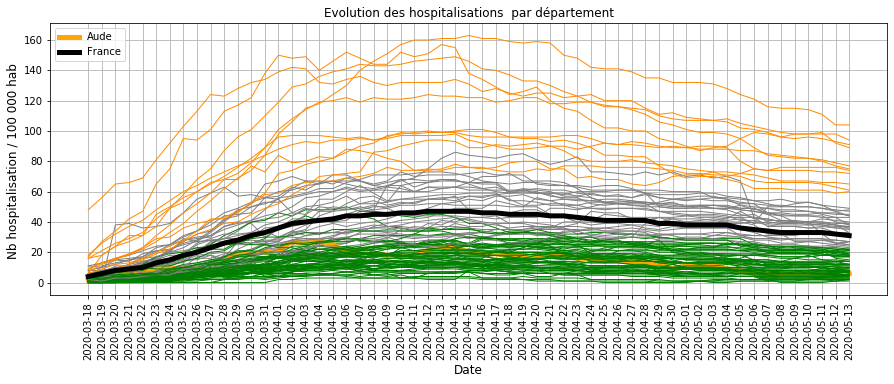

In [6]:
# Visualisation du taux d'hospitalisation de l'ensemble des départements ##
def courbe_Thosp(dep):
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if Dj.at[i,'jour'] == Dj['jour'].max() : # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            epaisseur = 1
            legende =''
            if Dj.at[i,'CTreprod'] > 0 :col = 'orange';epaisseur = 5;legende =Dj.at[i,'DEP']
            elif Dj.at[i,'CThosp'] == 2 :
                if  Dj.at[i,'CTreprod'] == 0 :col = 'darkorange';epaisseur = 1
                else:col = 'red';epaisseur = 3;legende =Dj.at[i,'DEP']
            elif Dj.at[i,'CThosp'] == 0 and Dj.at[i,'CTreprod'] == 0 :col ='green'
            else:col ='grey'
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black';legende =Dj.at[i,'DEP']
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'blue';legende =Dj.at[i,'DEP']
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],col,linewidth = epaisseur,label = legende)
    # Paramètres généraux
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution des hospitalisations  par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()  
    fig1.savefig('Images\Evolution des hospitalisations_' + dep + '.png')

    
courbe_Thosp('France')

#### Chiffre détaillé pour les départements critiques
- hosp : nombre d'hospitalisation du département (dep)
- Thosp : nombre d'hospitalisation pour 100 000 habitants
- Treprodmoy : nombre moyen d'entrée sur 1 semaine pour 100 hospitalisations

In [7]:
Dj.loc[(Dj['jour'] == Dj['jour'].max()) & (Dj['incoherence'] == False) \
           & ((Dj['CThosp'] ==2) | (Dj['CTreprod'] > 0))  & (Dj['dep'] != '999'), \
           ['dep','DEP','hosp','Thosp','Treprodmoy','CTreprod']].sort_values(by = ['Thosp', 'Treprodmoy' ],ascending = False)


,dep,DEP,hosp,Thosp,Treprodmoy,CTreprod
5414,94,Val-de-Marne,1449.0,104,0,0
3932,68,Haut-Rhin,731.0,94,1,0
5300,92,Hauts-de-Seine,1474.0,91,0,0
5186,90,Territoire de Belfort,130.0,89,0,0
4331,75,Paris,1701.0,77,0,0
5357,93,Seine-Saint-Denis,1215.0,75,1,0
3191,55,Meuse,142.0,74,2,0
5243,91,Essonne,947.0,72,0,0
3875,67,Bas-Rhin,747.0,65,1,0
5471,95,Val-d'Oise,751.0,61,0,0


#### Commentaires sur la situation des départements à la sortie du confinement (14 mai 2020) :

Les 11 premiers départements ci-dessus dont le nombre d'hospitalisation est le plus élevé ont une tendance à la baisse car les entrées sont faibles : cf. l'exemple qui suit sur le Val de Marne.

Le département de l'Aude a un nombre peu élevé d'hospitalisation mais le nombre d'entrée qui repart à la hausse amène à la vigilance : cf. l'exemple qui suit.

De plus il exsite de nombreux départements (VERT) qui ont été relativement peu touchés (10 fois moins).

### Evolution des entrées en hospitalisation par département

#### Courbe d'évolution pendant le confinement

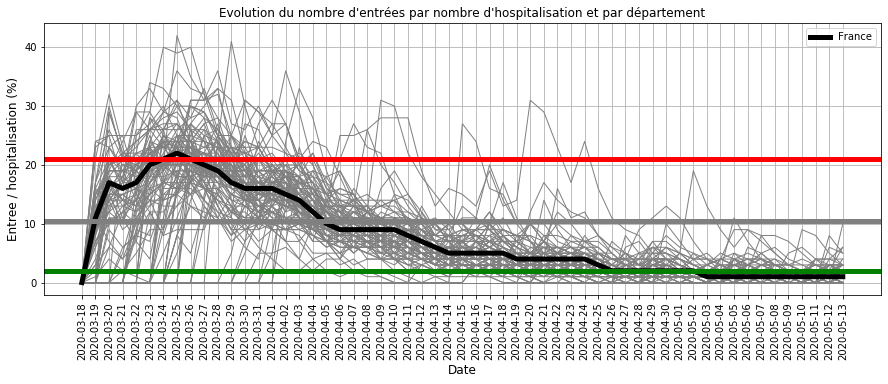

In [8]:
## Visualisation du taux d'hospitalisation de l'ensemble des départements pour vérifer la cohérence ##
def courbe_TEntree(dep):
#dep = '63'
    fig2 = pyplot.figure(2,figsize = (15, 5))
    for i in range(len(Dj)):
        if Dj.at[i,'jour'] == Dj['jour'].max(): # recherche de la dernière ligne du département
            couleur = 'grey'
            epaisseur = 1
            legende =''
            if  Dj.at[i,'dep'] == '999' : couleur = 'black' ; epaisseur = 5 ; legende='France'
            elif  Dj.at[i,'DEP'] == dep : couleur = 'blue' ; epaisseur = 5 ; legende=Dj.at[i,'DEP']
        # Courbe du département
            if Dj.at[i, 'incoherence'] == False:
                Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Treprodmoy']] # récupération du département
                pyplot.plot(Djdep['jour'],Djdep['Treprodmoy'],couleur,linewidth=epaisseur,label =legende)
    # Paramètres généraux
    pyplot.axhline(y = centreTreprod [2],color ='red',linewidth = 5)
    if centreTreprod [1] != 0 :
        pyplot.axhline(y = centreTreprod [1],color ='grey',linewidth = 5)
    pyplot.axhline(y = centreTreprod [0],color ='green',linewidth = 5)
    pyplot.title("Evolution du nombre d'entrées par nombre d'hospitalisation et par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Entree / hospitalisation (%)' , fontsize = 12) # titre des ordonnées
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.legend(loc='upper right')
    pyplot.show() 
courbe_TEntree('France')

#### Commentaires sur la propagation du virus en fin de confinement
2 phases dans l'évolution de la circulation pendant le confinement :
- jusqu'au 25 mars, tous les départements ont eu une augmentation significative des entrées (20 entrées pour 100 hospitalisaions) :
    - cela traduit une accélération de la circulation du virus,
    - et justifie à posteriori le passage en confinement pour la france entière,
- à partir du 15 avril, le nombre d'entrée a fortement baissé par rapport aux nombres d'hospitalisation (< 5  entrées pour 100 hospitalisations)
    - cela traduit une décroissance de la circulation du virus (4 fois moins par rapport au pic),
    - et donc montre l'impact significatif d'un confinement.

### Exemples d'évolution des hospitalisations pour les départements critiques

In [9]:
## Affichage  pour un département
def courbe_departement(dep):
    fig3 = pyplot.figure(2,figsize = (15, 5))
    if dep == 'France': couleur = 'black'
    else: couleur = 'blue' ;
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Thosp'],couleur,linewidth = 5,label='Hospitalisation / habitants (* 100 000)')
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprod'],'grey',linewidth = 1,label="Entrée / hospitalisations (* 100)")
    pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprodmoy'],'darkgrey',linewidth = 5,label="Entrée moyenne sur 7 jours /  hospitalistion (*100)")
    pyplot.legend(loc='upper left')
    pyplot.grid()
    pyplot.title("Evolution des hospitalisations et des entrées pour le département : "+ Dj[Dj['DEP'] == dep]['DEP'].max() )
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Taux' , fontsize = 12) # titre des ordonnées
    # mise en forme du label des x (rotation verticale)
    for label in pyplot.gca().xaxis.get_ticklabels():
        label.set_rotation(90)
    pyplot.show()  
# courbe_departement('France')

In [10]:
# Sert à faire une interface qui selectionne un département
# rq : la sauvegarde en Markdown ne se fait pas correctement
def courbes_departement(dep):
    courbe_departement(dep)
    courbe_Thosp(dep)
    courbe_TEntree(dep)

#### Val-de-Marne : les hospitalisations sont élevée mais la tendance est à la baisse
c'est un exemple de département dont :
- le nombre d'hospitalisation est certes élevé (BLEU sur le 1er  graphique)
- mais le nombre d'entrée est devenu faible (BLEU sur le 2ème graphique) ce qui se traduit par une tendance à la baisse

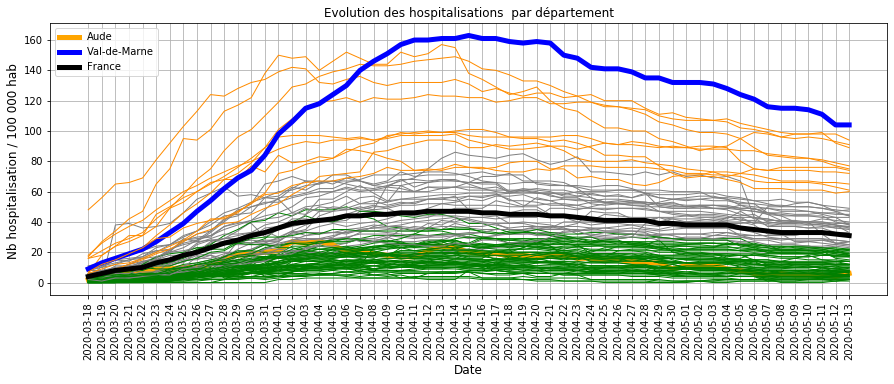

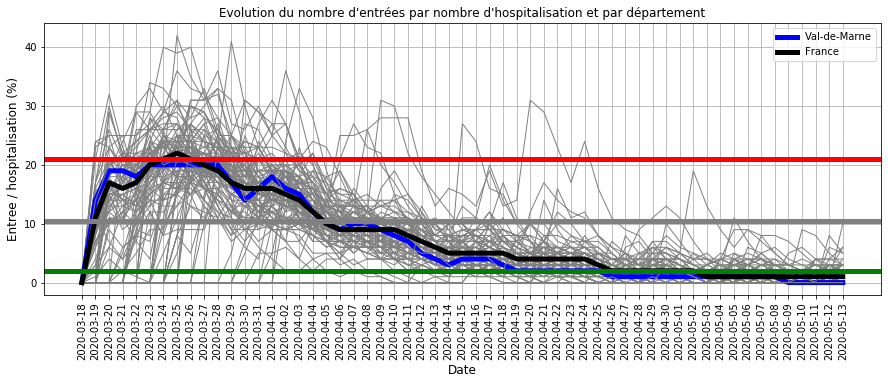

In [11]:
courbe_Thosp('Val-de-Marne')
courbe_TEntree('Val-de-Marne')

#### Département de l'Aude : une augmentation récente des entrées nécessite de la vigilence. 
- le nombre d'entrée repart à la hausse (GRIS sur le 1er graphique)
- cette hausse est élevée par rapport à la tendance des autres département (BLEU sur le 2ème graphique)
- mais le nombre d'hospitalisation est encore relativement faible (BLEU sur le 3e graphique)

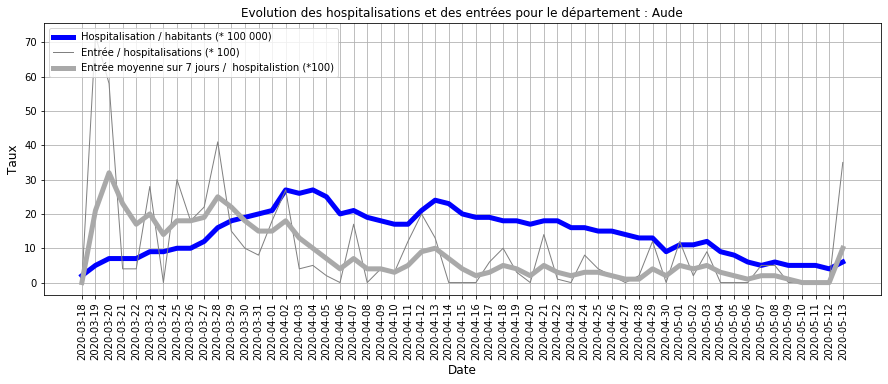

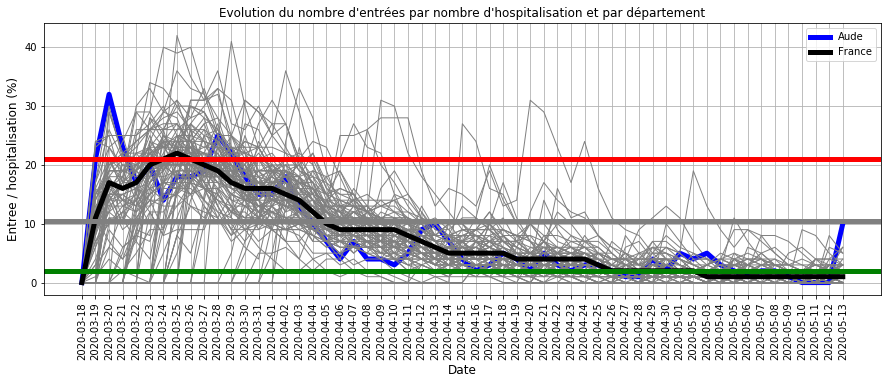

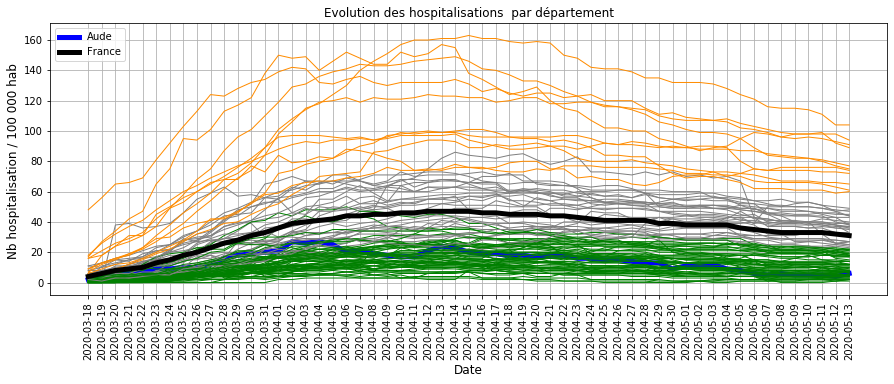

In [12]:
courbe_departement('Aude')
courbe_TEntree('Aude')
courbe_Thosp('Aude')

## Identification des différentes  évolutions pendant le confinement
L'objectif est de donner une piste de réflexion sur les  critères influençant l'impact du confinement.

### Regroupement des départements par l'analyse des composantes principales
Il s'agit de rechercher quelques courbes caractéristiques de l'évolution des hospitalisations pendant le confinement dont la combinaison permettrait d'expliquer de décrire l'évolution de chaque département.

### Construction du modèle

In [13]:
# Importation des librairies pour l'analyse des composantes principales
from sklearn import datasets
from sklearn import decomposition

In [14]:
# Les variables à expliquer sont les taux d'hospitalisation quotidients (variable jour) 
#  associés à chaque département (individu)
X = Dj.loc[:,['DEP','jour','Thosp']]
X = X.pivot(index = 'DEP', columns = 'jour', values = 'Thosp')

### Impact des différentes composantes

Text(0, 0.5, '% impact')

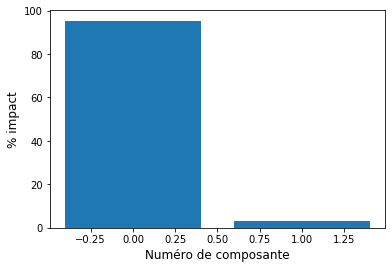

In [15]:
pca = decomposition.PCA() #création de l'analyse
pca.n_components = 2 # Choix de 2 composantes (en dessous de 1, indique le % de variances à expliquer)
pca.fit(X)
# ratio de la variance expliquée (visualisation graphique de chaque composante)
pyplot.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ * 100)
pyplot.xlabel('Numéro de composante' , fontsize = 12) # titre des absisses
pyplot.ylabel('% impact' , fontsize = 12) # titre des absisses

Les deux premières composantes expliquent 98 % de la courbe de l'évolution des hospitalisations de chaque département.
Les composantes suivantes sont négligeables par rapport à ces deux composantes.

### Visualisation des courbes caractéristiques qui décrivent l'évolution par département

Text(0, 0.5, 'nb hospitalisation / 100 000 habitants')

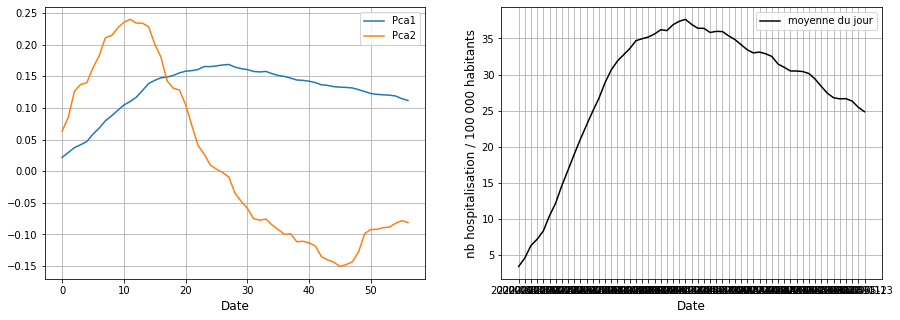

In [16]:
# affichage des coordonnées des axes principaux
# cela montre l'impact de chaque composante par rapport à la moyenne du jour (en non en absolue)
pyplot.figure(5,figsize = (15, 5))
pyplot.subplot(1,2,1)
pyplot.plot(pca.components_[0,:],label='Pca1')
pyplot.plot(pca.components_[1,:],label='Pca2')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
pyplot.subplot(1,2,2)
pyplot.plot(X.mean(),label ='moyenne du jour',color='black')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
pyplot.ylabel('nb hospitalisation / 100 000 habitants' , fontsize = 12) # titre des absisses

Le poids de la première composante (courbe bleue) représente le décalage à la hausse ou à la baisse par rapport à l'évolution moyenne des hospitalisations quotidienne (courbe noire).
Cela traduit qu'un département a été  plus ou moins globalement impacté.

La deuxième composante (courbe orange) indique si un département a eu une évolution différente de la moyenne au début ou à la fin de la période :
- si le poids de la composante est positive : il y a eu une forte accélération au début et une forte décélération à la fin (cassure de la courbe plus marquée)
- si le poids de la composante est négative : il y a eu une faible accélération au début et  une faible décélération à la fin (courbe applatie)
- si le poids est nulle : la phase d'accélération au début et de décélération se rapprochent de la tendance moyenne.

### Classification des départements en fonction de la forme de l'évolution des hospitalisations

#### Poids de chaque composante par départements

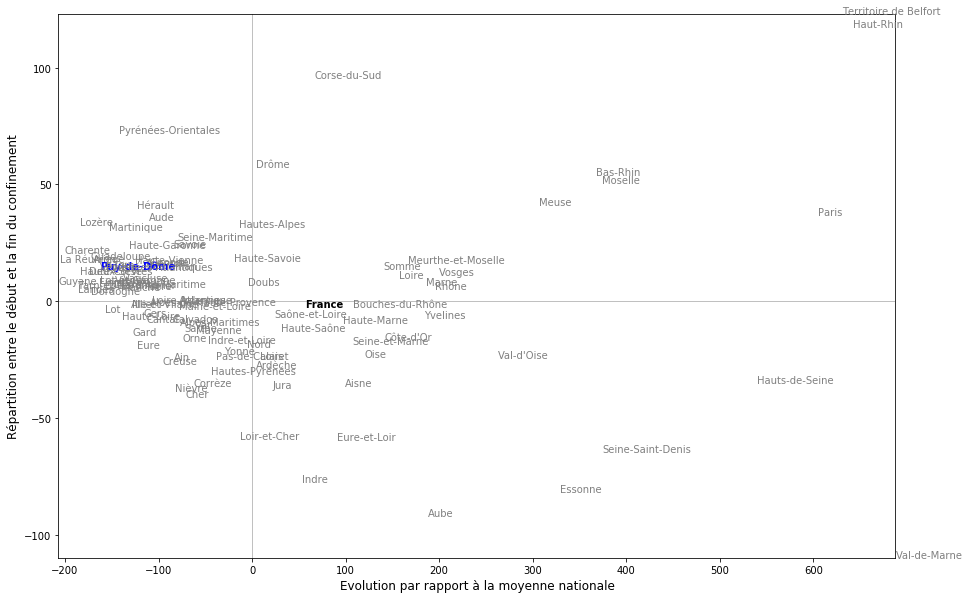

In [17]:
#pca.transform(X) # les coordonnées des points transformés sur les axes principaux (un point par ligne).
# Ca donne l'impact de chaque composante sur le département
# remarques ces axes principaux sont centrés sur les moyennes de chaque journée

#positionnement des individus dans le premier plan
fig, axes = pyplot.subplots(figsize=(15,10))
axes.set_xlim(pca.transform(X)[:,0].min(),pca.transform(X)[:,0].max()) #même limites en abscisse
axes.set_ylim(pca.transform(X)[:,1].min(),pca.transform(X)[:,1].max()) #et en ordonnée
#placement des étiquettes des observations
for i in range(len(X)):
    col ='grey'
    police = 'normal'
    if  X.index[i] == 'France': col = 'black';police = 'bold'
    if  X.index[i] == 'Puy-de-Dôme': col = 'blue';police = 'bold'
    if Dj.loc[(Dj['DEP'] == X.index[i]) & (Dj['jour'] == Dj['jour'].max())]['incoherence'].any() == True: col = 'red'
    pyplot.annotate(X.index[i],(pca.transform(X)[i,0],pca.transform(X)[i,1]),color=col,fontweight = police)
#ajouter les axes
pyplot.plot([pca.transform(X)[:,0].min(),pca.transform(X)[:,0].max()],[0,0],color='silver',linestyle='-',linewidth=1)
pyplot.plot([0,0],[pca.transform(X)[:,1].min(),pca.transform(X)[:,1].max()],color='silver',linestyle='-',linewidth=1)
pyplot.xlabel('Evolution par rapport à la moyenne nationale' , fontsize = 12) # titre des absisses
pyplot.ylabel('Répartition entre le début et la fin du confinement' , fontsize = 12) # titre des absisses
#affichage
pyplot.show()


#### Interprétation des différentes catégories : 
- en haute à droite : département fortement impacté avec une baisse relativement plus significative en fin de période (Haut-Rhin / courbe orange ci-dessous)
- en bas à droite : département fortement impacté et dont la tendance s'est relativement peu améliorée (Val-de-Marne / courbe rouge ci-dessous)
- à droite de la France : département moyennement impacté (Rhône / courbe violette)
- à gauche de la France: département peu impacté (Puy-de-Dôme / courbe bleue)
- à gauche de la France et en dessous : département dont la tendance se dégrade  (Indre / courbe rose)
- à gauche de la France et au dessus : département dont le confinement a fortement ralenti la progression (Pyrénées Orientales / courbe verte)

#### Illustration des différentes catégories

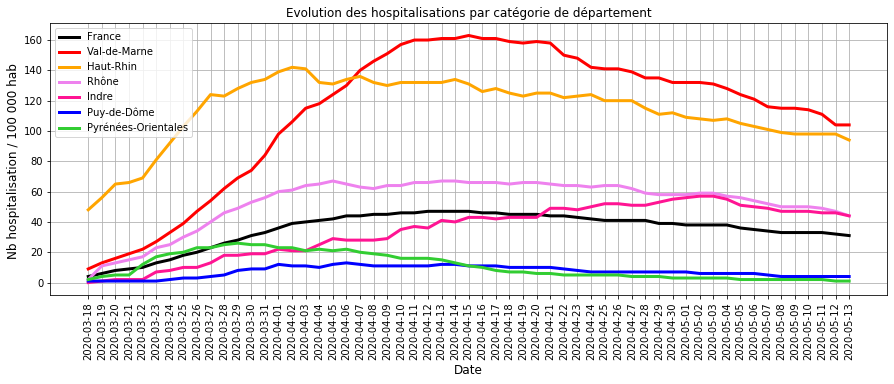

In [18]:
ldep = ['France','Val-de-Marne','Haut-Rhin','Rhône','Indre','Puy-de-Dôme','Pyrénées-Orientales']
lcol = ['black','red','orange','violet','deeppink','blue','limegreen']
fig6 = pyplot.figure(6,figsize = (15, 5))
for dep in range(len(ldep)):
       # if Dj.at[i,'jour'] == Dj['jour'].max() : # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
    epaisseur = 3
    legende =''
    col ='grey'
    # Courbe du département       
    Djdep = Dj.loc[Dj['DEP'] == ldep[dep],['jour','Thosp']] # récupération du département
    pyplot.plot(Djdep['jour'],Djdep['Thosp'],lcol[dep],linewidth = epaisseur,label = ldep[dep])
    # Paramètres généraux
pyplot.legend(loc='upper left')
pyplot.title("Evolution des hospitalisations par catégorie de département")
pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
    label.set_rotation(90)
pyplot.grid() # grille
pyplot.show()  
fig6.savefig('Images\Evolution des hospitalisations par catégorie de département.png')


#### Piste de réflexion pour la suite
Alors que la situation hospitalière est proche en début de confinement (à l'exception du Haut-Rhin), cette comparaison met en évidence que malgré les règles uniformes et strictes du confinement, l'évolution des hospitalisations n'a pas été identique dans tous les départements.

La recherche des causes de cette différence est une piste pour mieux comprendre comment le confinement impacte la circulation du virus et l'évolution des hospitalisations.

## Sauvegarde des fichiers

### Sous Markdown

In [22]:
# Commande enrgistrement
!jupyter nbconvert --to markdown --no-input  Evolution_confinement.ipynb

[NbConvertApp] Converting notebook Evolution_confinement.ipynb to markdown
[NbConvertApp] Support files will be in Evolution_confinement_files\
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Making directory Evolution_confinement_files
[NbConvertApp] Writing 11975 bytes to Evolution_confinement.md


### Sous HTML

In [20]:
# Commande enrgistrement
!jupyter nbconvert --to html --no-input  Evolution_confinement.ipynb

[NbConvertApp] Converting notebook Evolution_confinement.ipynb to html
[NbConvertApp] Writing 2532534 bytes to Evolution_confinement.html


## Annexe

### Interface pour visualiser un département

In [21]:
# Création d'un widget pour saisir un département 
def donnees_departement(dep):
    courbes_departement(dep)
    return Dj.loc[Dj['DEP'] == dep,['dep','DEP','jour','hosp','rad','dc','Entree','Sortie','Thosp','CThosp','Treprod','Treprodmoy','CTreprod','incoherence']]
interact(donnees_departement, dep =  Dj[Dj['jour'] == Dj['jour'].max()]['DEP'],value='Puy-de-Dôme')

interactive(children=(Dropdown(description='dep', options=('Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence'…

<function __main__.donnees_departement(dep)>